# Studying Random Forest Biasing On CMNIST

## Obiettivo

L'obiettivo di questa tesi triennale è osservare il biasing di modelli semplici di Machine Learning come il Random Forest. Per far questo utilizzeremo una derivazione del dataset MNIST in cui per ogni numero è associato un colore. In particolare utilizzeremo un dataset in cui il 95% delle immagini di un numero avranno il colore corretto (anche detti *aligned*), mentre il restante 5% avrà un colore relativo agli altri numeri (anche detti *conflicting*). Pertanto l'obiettivo è quello studiare le performance del logisitic regression Random Forest sugli *aligned* per ogni classe e le performance del modello sui *conflicting* per ogni classe.

Successivamente, prenderemo delle feature estratte da una rete neurale pre-allenata (un vettore) per rispondere alla seguente domanda: Il Random Forest prende il bias indipendentemente dal tipo di classificatore? Oppure può derivare dal tipo di rappresentazione del dato?

**Nota:** il vettore in questione non sarà più corrispondende ai pixel di un'immagine ma corrisponderà a delle caratteristiche imparate (in qualche modo) dalla rete neurale.

## Roadmap

Di seguito mostreremo la roadmap per raggiungere il nostro obiettivo:
1. Importazione dataset e definizione di training, validation e testing set. ✅
2. Inizializzazione Random Forest e training. 🚧
3. (Tuning parametri Random Forest con validation set).
4. Testing:
    - Performance su *aligned* per ogni classe.
    - Performance su *conflicting* per ogni classe.
5. Importazione features da rete neurale pre-allenata.
6. Testing con features.
7. Conclusioni.

## Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Importazione dataset

Prima di importare il dataset abbiamo bisogno di definire chiaramente il tipo di dato su cui andremo a lavorare. Il dataset è composto da immagini, pertano utilizzeremo la libreria *opencv* per andare a leggere ciascuna immagine che sarà di dimensione 28x28x3, dove 28x28 sono il numero di pixel e 3 sono i canali RGB di ciascuna immagine. 

Dal momento che il modello Random Forest lavora esclusivamente su istanze descritte da vettori e non da matrici, avremo bisogno di eseguire il *flatten* su ciascuna immagine così da avere un vettore 2352x1. Eseguendo questa operazione su ciascuna immagine otterremo il nostro input per il Random Forest. 

Per quanto riguarda i valori di output (e quindi la classificazione prodotta dal nostro modello), avremo bisogno di due liste:
- Y: corrisponde alle etichette di classe dell'oggetto di input (per esempio se l'immagine è uno 0, nella Y vi sarà uno 0)
- Y_bias: descrive la presenza o assenza di bias per ciascun oggetto di input, in particolare conterrà il valore relativo al colore assunto da quel numero.

Per definire tali liste andremo ad analizzare il nome del file di ciascuna immagine, il quale formate è il seguente "x_y_z.png", dove:
- x: è l'identificativo dell'immagine
- y: è l'etichetta di classe dell'immagine
- z: è il bias dell'immagine

Di conseguenza Y sarà composta dalle *y* di ciascuna immagine e Y_bias sarà composta dalle *z* di ciascuna immagine.

Infine, le directory del nostro dataset sono già strutturate in modo ottimo tra dataset di training, validation e testing, pertanto non avremo bisogno di dividere "manualmente" questi insiemi ma avremo bisogno solamente di leggere le giuste cartelle.

### Funzione per la lettura delle immagini

Per convenienza andremo a definire una funzione che possa essere chiamata su una cartella e restituisca rispettivamente X, Y e Y_bias:

In [2]:
def load_images_bias(folder_path):
    X = []
    Y = []
    Y_bias = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img.flatten())

        parts = filename.split('_')
        y = int(parts[1])
        y_bias = int(parts[2].split('.')[0])
        Y.append(y)
        Y_bias.append(y_bias)

    return np.array(X), np.array(Y), np.array(Y_bias)

Inoltre definiamo una funzione che calcoli il numero totale di immagini nelle cartelle visionate, in modo da controllare se tutte le immagini sono state importate correttamente:

In [3]:
def count_total_images(folder_path):
    return len([f for f in os.listdir(folder_path)])

### Definizione dataset di training

A questo punto andiamo a definire il dataset di training che conterrà tutte le immagini nelle cartelle *align* e *conflict*:

In [4]:
X_train = []
Y_train = []
Y_train_bias = []

In [5]:
total_images = 0
folder_path = 'cmnist/5pct/'
numbers = [str(i) + "/" for i in range(10)]

for parent_folder in ['align/', 'conflict/']:
    for number in numbers:
        X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + parent_folder + number)
        X_train.extend(X_batch)        
        Y_train.extend(Y_batch)
        Y_train_bias.extend(Y_bias_batch)
        total_images += count_total_images(folder_path + parent_folder + number)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train_bias = np.array(Y_train_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di training:

In [6]:
print(f"X_train shape      = {X_train.shape}")
print(f"Y_train shape      = {Y_train.shape}")
print(f"Y_train_bias shape = {Y_train_bias.shape}")
print(f"Total images       = {total_images}")

X_train shape      = (55000, 2352)
Y_train shape      = (55000,)
Y_train_bias shape = (55000,)
Total images       = 55000


## Definizione dataset di validation

A questo punto andiamo a definire il dataset di validation che conterrà tutte le immagini nella cartella "valid":

In [7]:
X_valid = []
Y_valid = []
Y_valid_bias = []

In [8]:
total_images = 0
folder_path = 'cmnist/5pct/valid/'

X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path)
X_valid.extend(X_batch)        
Y_valid.extend(Y_batch)
Y_valid_bias.extend(Y_bias_batch)
total_images = count_total_images(folder_path)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)
Y_valid_bias = np.array(Y_valid_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di validation:

In [9]:
print(f"X_valid shape      = {X_valid.shape}")
print(f"Y_valid shape      = {Y_valid.shape}")
print(f"Y_valid_bias shape = {Y_valid_bias.shape}")
print(f"Total images       = {total_images}")

X_valid shape      = (5000, 2352)
Y_valid shape      = (5000,)
Y_valid_bias shape = (5000,)
Total images       = 5000


## Definizione dataset di testing

A questo punto andiamo a definire il dataset di testing che conterrà tutte le immagini nella cartella "test".

**Nota:** dal momento che il nostro dataset è composto da diversi valori di correlazione, la cartella "test" si trova in un folder path diverso rispetto alle precedenti cartelle.

In [10]:
X_test = []
Y_test = []
Y_test_bias = []

In [11]:
total_images = 0
folder_path = 'cmnist/test/'

for number in numbers:
    X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + number)
    X_test.extend(X_batch)        
    Y_test.extend(Y_batch)
    Y_test_bias.extend(Y_bias_batch)
    total_images += count_total_images(folder_path + number)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test_bias = np.array(Y_test_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di testing:

In [12]:
print(f"Total images       = {total_images}")
print(f"X_test shape      = {X_test.shape}")
print(f"Y_test shape      = {Y_test.shape}")
print(f"Y_test_bias shape = {Y_test_bias.shape}")

Total images       = 10000
X_test shape      = (10000, 2352)
Y_test shape      = (10000,)
Y_test_bias shape = (10000,)


### Visualizzazione dataset

In questa sezione mostriamo una breve visualizzazione del dataset, mostrando le caratteristiche delle immagini con o senza bias. Iniziamo visualizzando il nostro dataset di training. Mostreremo come prima immagine l'immagine aligned di ogni numero, mentre le restanti immagini di ciascuna riga saranno *conflicting* rispetto a quel numero:

In [13]:
img_shape = (28, 28, 3)

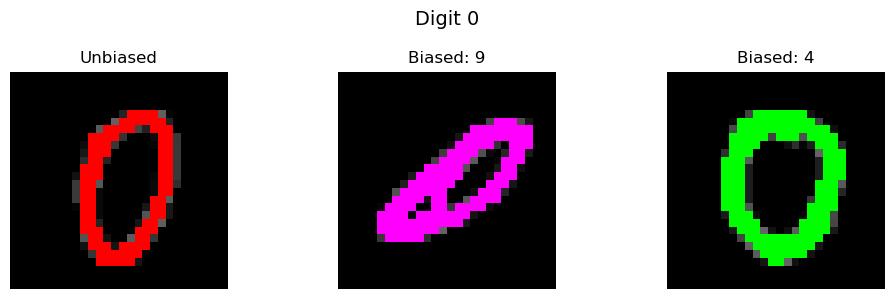

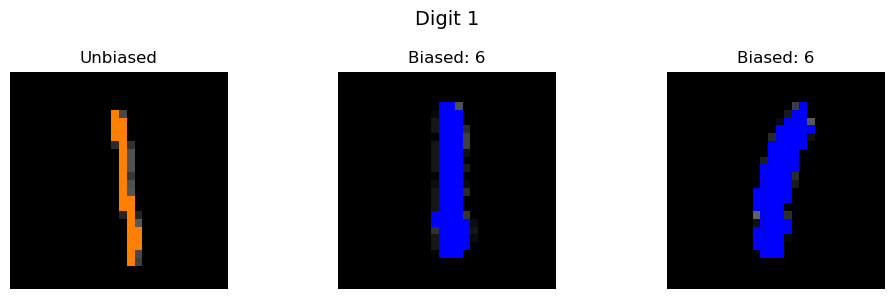

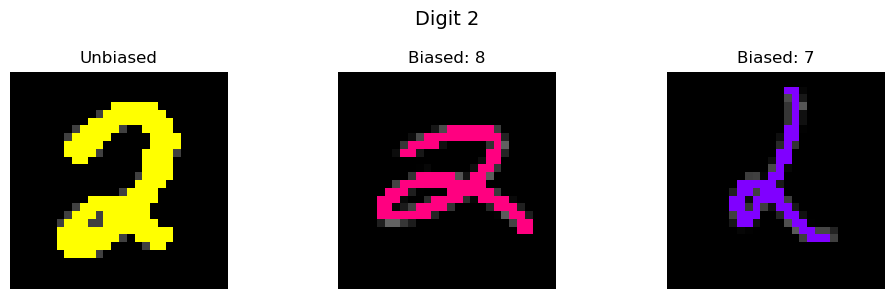

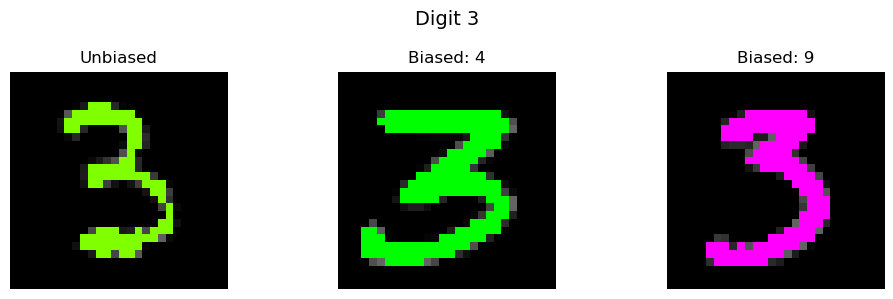

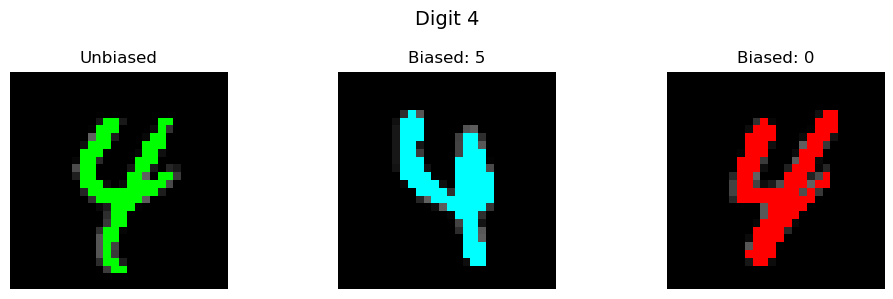

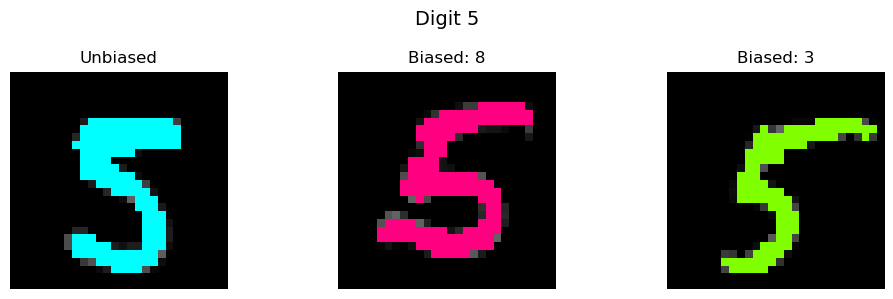

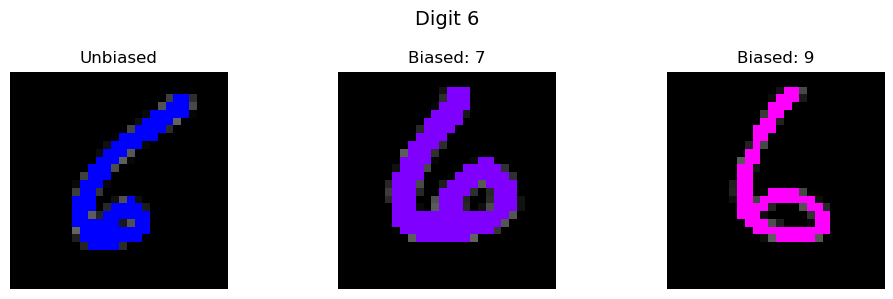

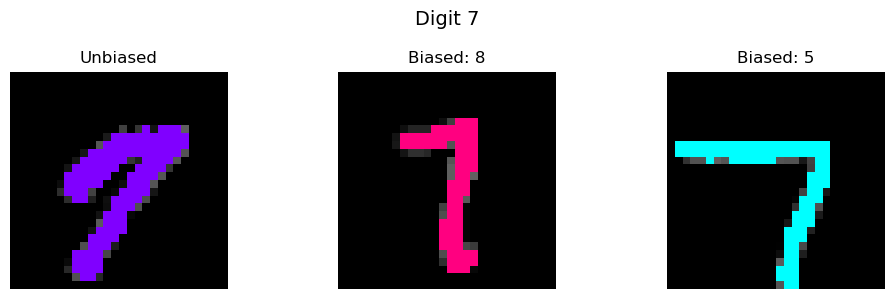

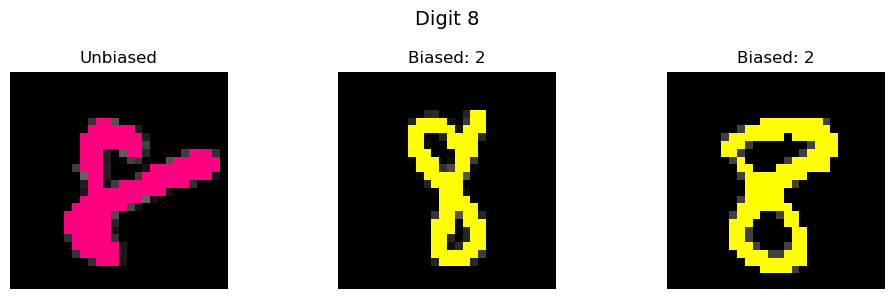

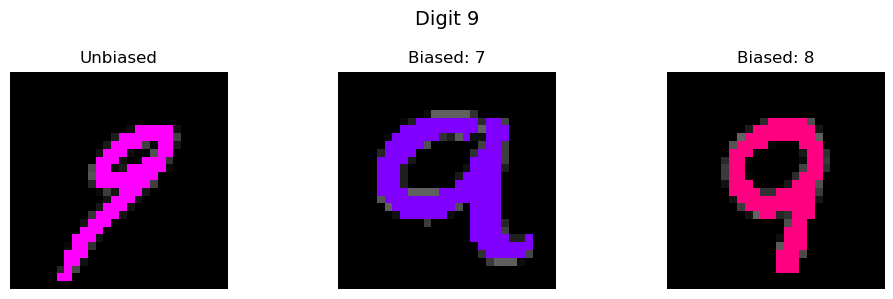

In [34]:
for digit in range(10):
    unbiased_idx = np.where((Y_train == digit) & (Y_train_bias == digit))[0]
    biased_idx = np.where((Y_train == digit) & (Y_train_bias != digit))[0]

    selected_indices = [unbiased_idx[0]] + list(biased_idx[:2])

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        img = X_train[idx].reshape(img_shape)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img.astype(np.uint8))
        title = "Unbiased" if i == 0 else f"Biased: {Y_train_bias[idx]}"
        plt.title(title)
        plt.axis('off')

    plt.suptitle(f"Digit {digit}", fontsize=14)
    plt.tight_layout()
    plt.show()

Invece per quanto riguarda il validation set e il training set, mostriamo 10 immagini per ciascun insieme: 

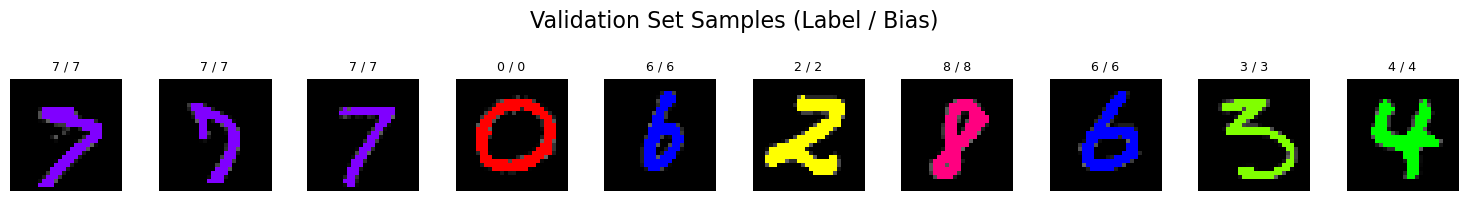

In [42]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Validation Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_valid.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_valid[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_valid[img_idx]} / {Y_valid_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

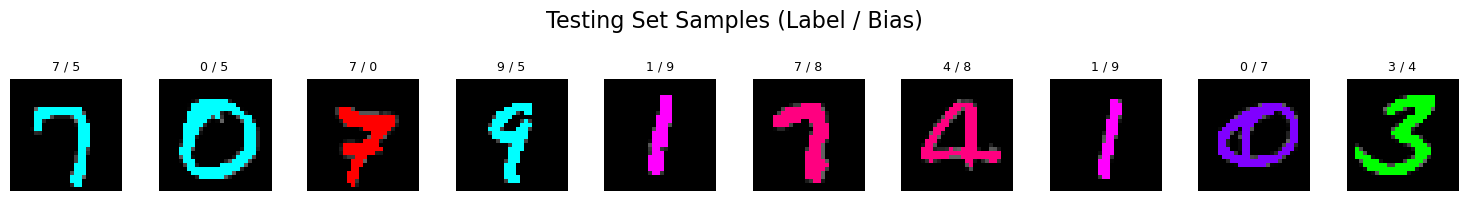

In [43]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Testing Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_test.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_test[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_test[img_idx]} / {Y_test_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()